In [1]:
!apt -qq -y install fonts-nanum
%pip install -U --quiet prince
%pip install --quiet statsmodels altair_viewer vega altair duckdb==0.8.1 altair_viewer

fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Variables

In [2]:
%config InlineBackend.figure_format = 'retina'
%cd /mnt

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd 
import altair as alt
import prince
from pprint import pprint
from pathlib import Path
import duckdb
def sqldf(query):
    return duckdb.query(query).to_df()

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

/mnt


In [3]:
font_path = Path('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
fontprop = fm.FontProperties(fname=font_path, size=14, weight="bold")

In [4]:
def series_not_in(series, notin_list):
    s = notin_list[1:]
    _ = series != notin_list[0]
    for __ in s:
        _ = _ & (series!=__)
    return _

# Loading Dataset

In [5]:
data = pd.read_csv("performance_data_new01.csv", sep=",", encoding="CP949")
data = data.loc[(data["model"] != "weighted_Ensemble")]
data.loc[data["score"].apply(pd.isna) & (data["score_type"] != "f1_score") & series_not_in(data["attempt"], [5, 1, 2, 9])] # precision === TP / (TP + FP) ==> (precision == NA) === "every ddata is TN or FN"

,model,attempt,score_type,attack_name,score
325,DNN,0,precision,SQLi,NaN
326,DNN,0,precision,File_Inclusion,NaN
373,DNN,3,precision,SQLi,NaN
374,DNN,3,precision,File_Inclusion,NaN
389,DNN,4,precision,SQLi,NaN
390,DNN,4,precision,File_Inclusion,NaN
421,DNN,6,precision,SQLi,NaN
422,DNN,6,precision,File_Inclusion,NaN
437,DNN,7,precision,SQLi,NaN
438,DNN,7,precision,File_Inclusion,NaN


In [6]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix


conf_matrix = pd.read_csv("confusion_matrix/DNN_attempt_01.csv", index_col=0)
def get_matrix_vals(cnf_matrix, _dict_=True):
    length = int(cnf_matrix.sum().sum())
    index = ["PW_Attack", "SQLi", "File_Inclusion", "XSS"]
    _FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  # column
    _FP.index = index
    _FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix) # rows
    _FN.index = index
    _TP = pd.Series(np.diag(cnf_matrix), index=index) 
    _TN = pd.Series([length for _ in range(4)], index=index) - (_FP + _FN + _TP) 
    
    if not _dict_: return {
        "FP":_FP, "FN":_FN, "TP":_TP, "TN":_TN, "length": length
    }
    return {"FP":_FP.to_dict(), "FN":_FN.to_dict(), "TP":_TP.to_dict(), "TN":_TN.to_dict(), "length": length}
def micro_f1(TP, FP, FN):
    return TP / (TP + (FP+FN)/2 )
def macro_f1(TP, FP, FN):
    return ( 1 / (( 1/(TP / (FP+TP)) + 1/(TP / (TP+FN)) ) / 2) ).fillna(0)
mat = get_matrix_vals(conf_matrix, False)
micro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN")), macro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN"))

(PW_Attack         0.908142
 SQLi              0.000000
 File_Inclusion    0.000000
 XSS               0.662345
 dtype: float64,
 PW_Attack         0.908142
 SQLi              0.000000
 File_Inclusion    0.000000
 XSS               0.662345
 dtype: float64)

In [7]:
import os, pathlib
confusion_matrix_path = pathlib.Path("confusion_matrix")
f1_micros = {}
for csv in os.listdir(confusion_matrix_path):
    filename = csv
    conf_matrix = pd.read_csv(os.path.join(confusion_matrix_path, csv), index_col=0)
    mat = get_matrix_vals(conf_matrix, False)
    model_name, attempt = csv.replace(".csv","").split("_attempt_")
    if f1_micros.get(model_name):
        f1_micros[model_name].append(
            micro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN"))
        )
    else:
        f1_micros[model_name] = [
            micro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN"))
        ]

In [8]:
f1_micro_list = []
attacks = ["PW_Attack", "SQLi", "File_Inclusion", "XSS"]
model_name = {
    "DNN": "DNN",
    'file_data':"P-LSTM",
    'payload':"H-LSTM",
    'result_confusion_matrix':"DPL",
    'result_weight_confusion_matrix':"DPL-weight",
    'file_data_LSTM':"P-LSTM",
    'payload_LSTM':"H-LSTM",
    'non_weighted_Ensemble':"DPL",
    'weighted_Ensemble':"DPL-weight",
    "form-LSTM":"P-LSTM",
    "H-LSTM":"H-LSTM",
    "DFL":"DPL",
    "DPL-weight":"DPL-weight",
}
for idx, model in enumerate(f1_micros):
    values = np.stack(f1_micros[model])
    values = pd.DataFrame(values, columns=attacks)
    values["model"] = model_name[model]
    values["attempt"] = idx + 1
    f1_micro_list.append(values)
f1_micro = pd.DataFrame(np.concatenate(f1_micro_list), columns=[*attacks, "model", "attempt"])

In [9]:
data['attack_name'].unique()

array(['PW_Injection', 'SQLi', 'File_Inclusion', 'XSS'], dtype=object)

In [10]:
attacks_map = {
    "PW_Injection":"PW_Attack", 
    "PW_Attack":"PW_Attack", 
    "SQLi":"SQLi", 
    "File_Inclusion":"File_Inclusion", 
    "XSS":"XSS",
}
attacks = ["PW_Attack", "SQLi", "File_Inclusion", "XSS"]
f1_micro_list = []
for attack in attacks:
    _ = f1_micro[[attack, "model", "attempt"]]
    _["attack_name"] = attack
    f1_micro_list.append(_)
f1_micro_type2 = pd.DataFrame(np.concatenate(f1_micro_list), columns=["score", "model", "attempt", "attack_name"])
f1_micro_type2

/tmp/ipykernel_30693/3833448393.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _["attack_name"] = attack
/tmp/ipykernel_30693/3833448393.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _["attack_name"] = attack
/tmp/ipykernel_30693/3833448393.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

,score,model,attempt,attack_name
0,0.908142,DNN,1,PW_Attack
1,0.908516,DNN,1,PW_Attack
2,0.908592,DNN,1,PW_Attack
3,0.909075,DNN,1,PW_Attack
4,0.909625,DNN,1,PW_Attack
...,...,...,...,...
195,0.661901,DPL-weight,5,XSS
196,0.652632,DPL-weight,5,XSS
197,0.655669,DPL-weight,5,XSS
198,0.652216,DPL-weight,5,XSS


In [11]:
f1_micro_type2["score_type"] = 'f1_micro'
_data = data.copy(True)
_data["model"] = data["model"].apply(lambda x: model_name[x])
_data["attack_name"] = data["attack_name"].apply(lambda x: attacks_map[x])
data = pd.concat([f1_micro_type2, _data])
data = sqldf("SELECT * FROM data WHERE model != 'DPL-weight' ")

In [12]:
data['score_type'].unique()

array(['f1_micro', 'accuracy', 'precision', 'recall', 'f1_score'],
      dtype=object)

In [13]:
sqldf("select * from data")

,score,model,attempt,attack_name,score_type
0,0.908142,DNN,1,PW_Attack,f1_micro
1,0.908516,DNN,1,PW_Attack,f1_micro
2,0.908592,DNN,1,PW_Attack,f1_micro
3,0.909075,DNN,1,PW_Attack,f1_micro
4,0.909625,DNN,1,PW_Attack,f1_micro
...,...,...,...,...,...
795,0.505310,DPL,9,XSS,recall
796,0.948298,DPL,9,PW_Attack,f1_score
797,1.000000,DPL,9,SQLi,f1_score
798,1.000000,DPL,9,File_Inclusion,f1_score


In [14]:
data["model"].unique()

array(['DNN', 'P-LSTM', 'H-LSTM', 'DPL'], dtype=object)

In [15]:
data["attack_name"].unique()

array(['PW_Attack', 'SQLi', 'File_Inclusion', 'XSS'], dtype=object)

In [16]:
from typing import Literal
def get_info(data, model_name:Literal['DNN', 'P-LSTM', 'H-LSTM', 'DPL',], attack_name:Literal['PW_Injection', 'SQLi', 'File_Inclusion', 'XSS']):
    RESULT = data.loc[(data["model"] == model_name) & (data["attack_name"] == attack_name)]
    return [
        {"precision_avg":RESULT.loc[RESULT["score_type"] == "precision"]["score"].sum() / 10, "precision_std": RESULT.loc[RESULT["score_type"] == "precision"]["score"].std() },
        {"accuracy_avg":RESULT.loc[RESULT["score_type"] == "accuracy"]["score"].sum() / 10, "accuracy_std": RESULT.loc[RESULT["score_type"] == "accuracy"]["score"].std() },
        {"recall_avg":RESULT.loc[RESULT["score_type"] == "recall"]["score"].sum() / 10, "recall_std": RESULT.loc[RESULT["score_type"] == "recall"]["score"].std() },
        {"f1_score_avg":RESULT.loc[RESULT["score_type"] == "f1_score"]["score"].sum() / 10, "f1_score_std": RESULT.loc[RESULT["score_type"] == "f1_score"]["score"].std() },
    ]

In [17]:
DNN_XSS = data.loc[(data["model"] == "DNN") & (data["attack_name"] == "XSS")]
[
    {"precision_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "precision"]["score"].sum() / 10, "precision_std": DNN_XSS.loc[DNN_XSS["score_type"] == "precision"]["score"].std() },
    {"accuracy_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "accuracy"]["score"].sum() / 10, "accuracy_std": DNN_XSS.loc[DNN_XSS["score_type"] == "accuracy"]["score"].std() },
    {"recall_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "recall"]["score"].sum() / 10, "recall_std": DNN_XSS.loc[DNN_XSS["score_type"] == "recall"]["score"].std() },
    {"f1_score_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "f1_score"]["score"].sum() / 10, "f1_score_std": DNN_XSS.loc[DNN_XSS["score_type"] == "f1_score"]["score"].std() },
]

[{'precision_avg': 1.0, 'precision_std': 0.0},
 {'accuracy_avg': 0.9135390225590792, 'accuracy_std': 0.001542443515691891},
 {'recall_avg': 0.4929654487218104, 'recall_std': 0.0073671217275911634},
 {'f1_score_avg': 0.6603549560014352, 'f1_score_std': 0.006600592495298415}]

In [18]:
get_info(data, "DNN", "XSS")

[{'precision_avg': 1.0, 'precision_std': 0.0},
 {'accuracy_avg': 0.9135390225590792, 'accuracy_std': 0.001542443515691891},
 {'recall_avg': 0.4929654487218104, 'recall_std': 0.0073671217275911634},
 {'f1_score_avg': 0.6603549560014352, 'f1_score_std': 0.006600592495298415}]

In [19]:
result = {}
for attack_name in data["attack_name"].unique():
    for model_name in data["model"].unique():
        if not result.get(attack_name):
            result[attack_name] = {}
        result[attack_name][model_name] = get_info(data, model_name, attack_name)
pprint(result)

{'File_Inclusion': {'DNN': [{'precision_avg': 0.0, 'precision_std': nan},
                            {'accuracy_avg': 0.9795216474205425,
                             'accuracy_std': 0.0007151851542928706},
                            {'recall_avg': 0.0, 'recall_std': 0.0},
                            {'f1_score_avg': 0.0, 'f1_score_std': nan}],
                    'DPL': [{'precision_avg': 0.9, 'precision_std': 0.0},
                            {'accuracy_avg': 0.99799435129241,
                             'accuracy_std': 0.006342418102157446},
                            {'recall_avg': 0.9,
                             'recall_std': 0.31622776601683794},
                            {'f1_score_avg': 0.9, 'f1_score_std': 0.0}],
                    'H-LSTM': [{'precision_avg': 0.0, 'precision_std': 0.0},
                               {'accuracy_avg': 0.979446569661435,
                                'accuracy_std': 0.0007051160574686685},
                               {'recall_avg'

In [20]:
HLSTM_XSS = data.loc[(data["model"] == "DNN") & (data["attack_name"] == "XSS")]
[
    {"precision_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "precision"]["score"].sum() / 10, "precision_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "precision"]["score"].std() },
    {"accuracy_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "accuracy"]["score"].sum() / 10, "accuracy_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "accuracy"]["score"].std() },
    {"recall_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "recall"]["score"].sum() / 10, "recall_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "recall"]["score"].std() },
    {"f1_score_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "f1_score"]["score"].sum() / 10, "f1_score_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "f1_score"]["score"].std() },
]

[{'precision_avg': 1.0, 'precision_std': 0.0},
 {'accuracy_avg': 0.9135390225590792, 'accuracy_std': 0.001542443515691891},
 {'recall_avg': 0.4929654487218104, 'recall_std': 0.0073671217275911634},
 {'f1_score_avg': 0.6603549560014352, 'f1_score_std': 0.006600592495298415}]

In [21]:
nans = data.loc[data["score"].apply(pd.isna) & (data["score_type"] != "f1_score") & series_not_in(data["attempt"], [5, 1, 2, 9])]
strs = {
    "file_data_LSTM": "file_data",
    "payload_LSTM": "payload",
    "DNN": "DNN",
    "non_weighted_Ensemble": 'result_confusion_matrix',
}
nan_matrix_list = [[file_name, pd.read_csv(file_name)] for file_name in list("confusion_matrix/"+nans["model"].apply(lambda x: strs[x])+"_attempt_"+nans["attempt"].apply(lambda x: str(x+1).zfill(2))+".csv")]

In [22]:
analysis_no_nan = sqldf("""
                        SELECT model, score_type, attack_name, SUM(score) / COUNT(*) as M, COUNT(*) AS N 
                        FROM data 
                        WHERE NOT data.score IS NULL
                        GROUP BY model, score_type, attack_name""")
analysis = sqldf("""SELECT model, score_type, attack_name, SUM(score) / COUNT(*) as M, COUNT(*) AS N 
                        FROM data 
                        GROUP BY model, score_type, attack_name""")

In [23]:
analysis["score_type"].unique()

array(['f1_micro', 'accuracy', 'precision', 'recall', 'f1_score'],
      dtype=object)

In [24]:
analysis

,model,score_type,attack_name,M,N
0,DNN,f1_micro,PW_Attack,0.908211,10
1,P-LSTM,f1_micro,PW_Attack,0.904107,10
2,H-LSTM,f1_micro,PW_Attack,0.000000,10
3,DPL,f1_micro,PW_Attack,0.945143,10
4,DNN,f1_micro,SQLi,0.000000,10
5,P-LSTM,f1_micro,SQLi,1.000000,10
6,H-LSTM,f1_micro,SQLi,0.104237,10
7,DPL,f1_micro,SQLi,1.000000,10
8,DNN,f1_micro,File_Inclusion,0.000000,10
9,P-LSTM,f1_micro,File_Inclusion,0.900000,10


In [25]:
sqldf("""
      SELECT *
      FROM analysis_no_nan
      WHERE score_type = 'precision'
      """)

,model,score_type,attack_name,M,N
0,P-LSTM,precision,PW_Attack,0.825037,10
1,P-LSTM,precision,SQLi,1.000000,10
2,P-LSTM,precision,File_Inclusion,1.000000,9
3,P-LSTM,precision,XSS,1.000000,9
4,H-LSTM,precision,PW_Attack,0.000000,10
5,H-LSTM,precision,SQLi,0.054985,10
6,H-LSTM,precision,File_Inclusion,0.000000,10
7,H-LSTM,precision,XSS,1.000000,6
8,DNN,precision,PW_Attack,0.831858,10
9,DNN,precision,XSS,1.000000,10


In [26]:
sqldf("""
        SELECT *
        FROM analysis_no_nan
        WHERE 1=1
            -- AND score_type = 'precision'
            -- AND model = 'payload_LSTM'
        ORDER BY score_type, attack_name
      """)

,model,score_type,attack_name,M,N
0,H-LSTM,accuracy,File_Inclusion,0.979447,10
1,DPL,accuracy,File_Inclusion,0.997994,10
2,P-LSTM,accuracy,File_Inclusion,0.997994,10
3,DNN,accuracy,File_Inclusion,0.979522,10
4,H-LSTM,accuracy,PW_Attack,0.094215,10
5,P-LSTM,accuracy,PW_Attack,0.838322,10
6,DNN,accuracy,PW_Attack,0.845990,10
7,DPL,accuracy,PW_Attack,0.911533,10
8,H-LSTM,accuracy,SQLi,0.191019,10
9,DNN,accuracy,SQLi,0.952930,10


In [27]:
%config InlineBackend.figure_format = 'svg'

# 성능평가

## score_type - Attack Name

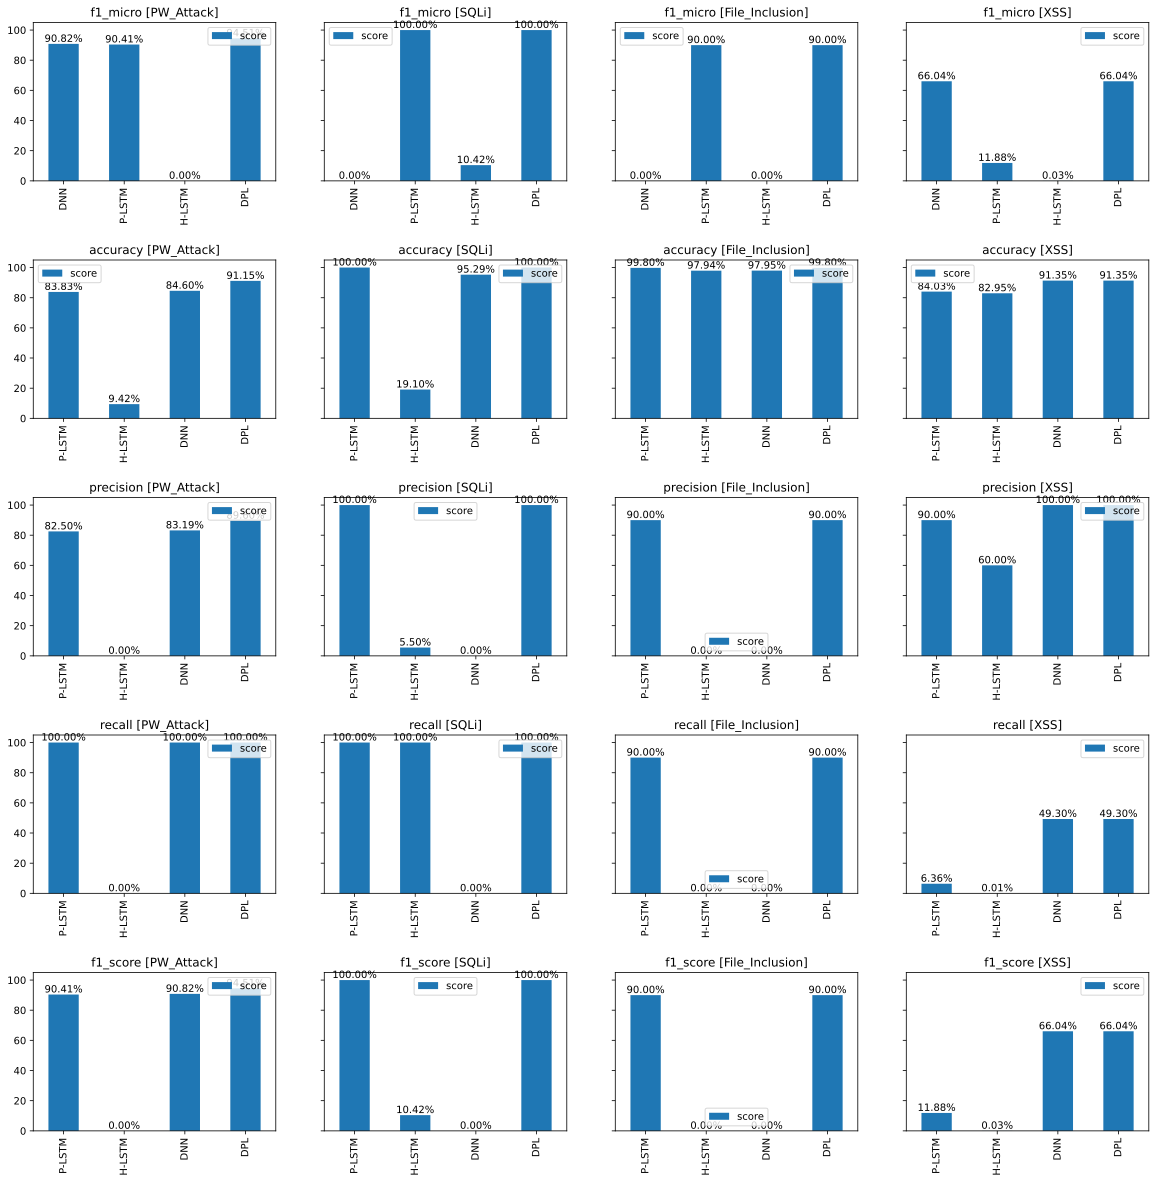

In [28]:

plt.rcParams['figure.figsize'] = [30, 50]
plt.rcParams['figure.dpi'] = 200

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharey=True)
fig.subplots_adjust(hspace=.5)

for ix, attack_name in enumerate(sqldf("SELECT DISTINCT attack_name FROM analysis")["attack_name"]):
  for iy, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"]):
    _df = sqldf(f"""
          SELECT model AS model_name, M * 100 as score 
          FROM analysis
          WHERE score_type = '{score_type}'
            AND attack_name = '{attack_name}'
          """)
    plot = _df.plot(x="model_name", y=["score"], kind='bar', subplots=True, figsize=(7,3), title=[f"{score_type} [{attack_name}]"], ax=axes[iy, ix], xlabel="")
    for bars in axes[iy, ix].containers:
      axes[iy, ix].bar_label(bars, fmt="%.2f%%")

## Model - Attack Name

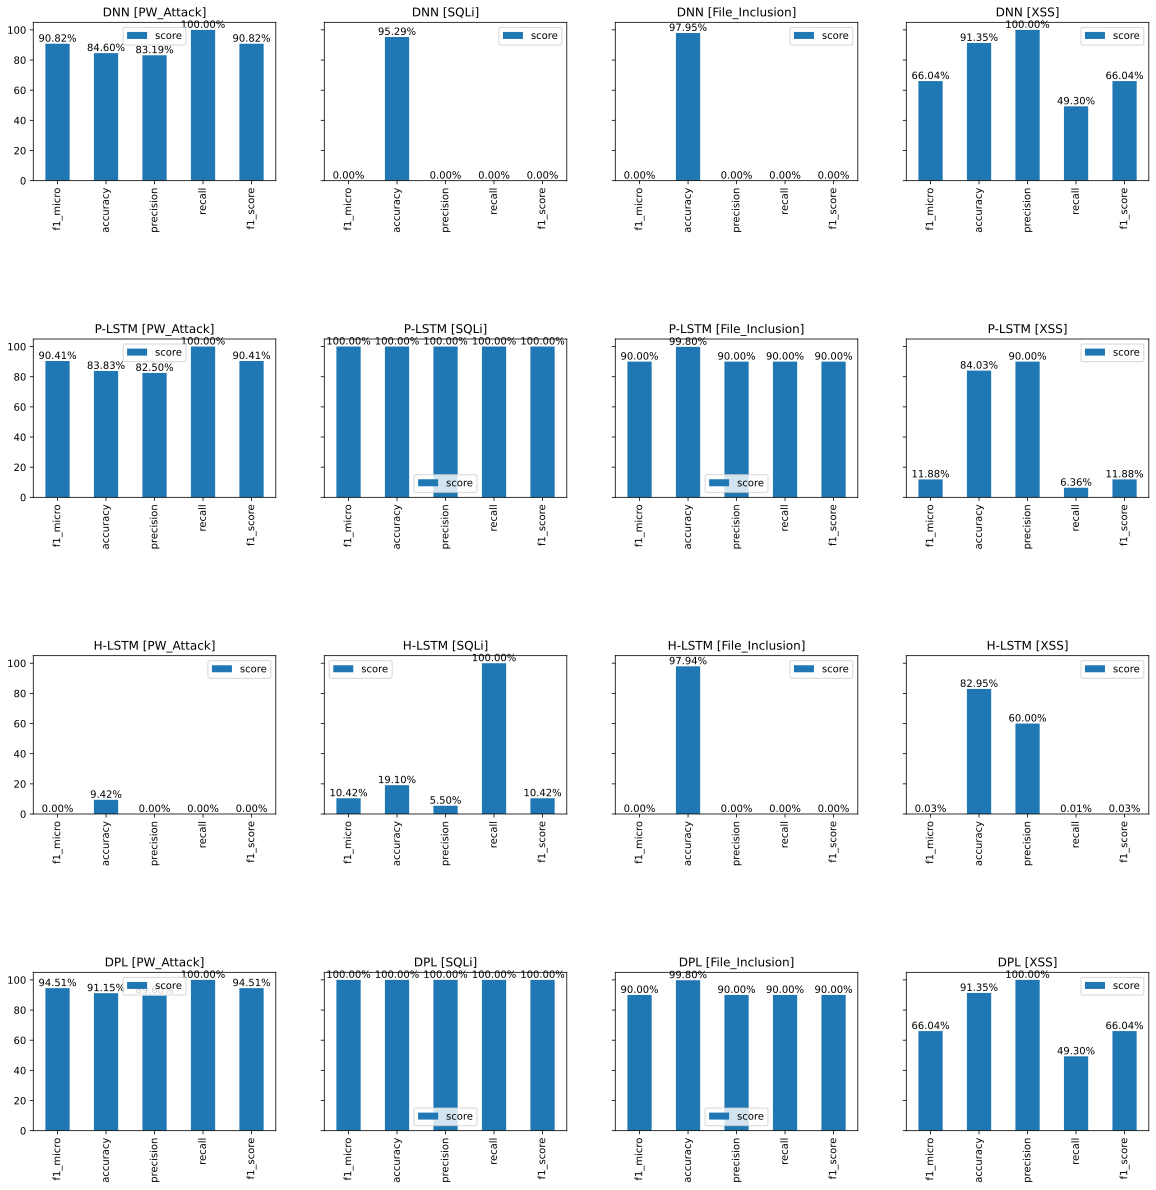

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)
fig.subplots_adjust(hspace=1)
for ix, attack_name in enumerate(sqldf("SELECT DISTINCT attack_name FROM analysis")["attack_name"]):
  for iy, model in enumerate(sqldf("SELECT DISTINCT model FROM data")["model"]):
    sqldf(f"""
          SELECT score_type, M*100 as score 
          FROM analysis
          WHERE model = '{model}'
            AND attack_name = '{attack_name}'
          """).plot(x="score_type", y=["score"], kind='bar', subplots=True, figsize=(7,3), title=[f"{model} [{attack_name}]"], ax=axes[iy, ix], xlabel="")
    for bar in axes[iy, ix].containers:
      axes[iy, ix].bar_label(bar, fmt="%.2f%%")

## Model - Score Type

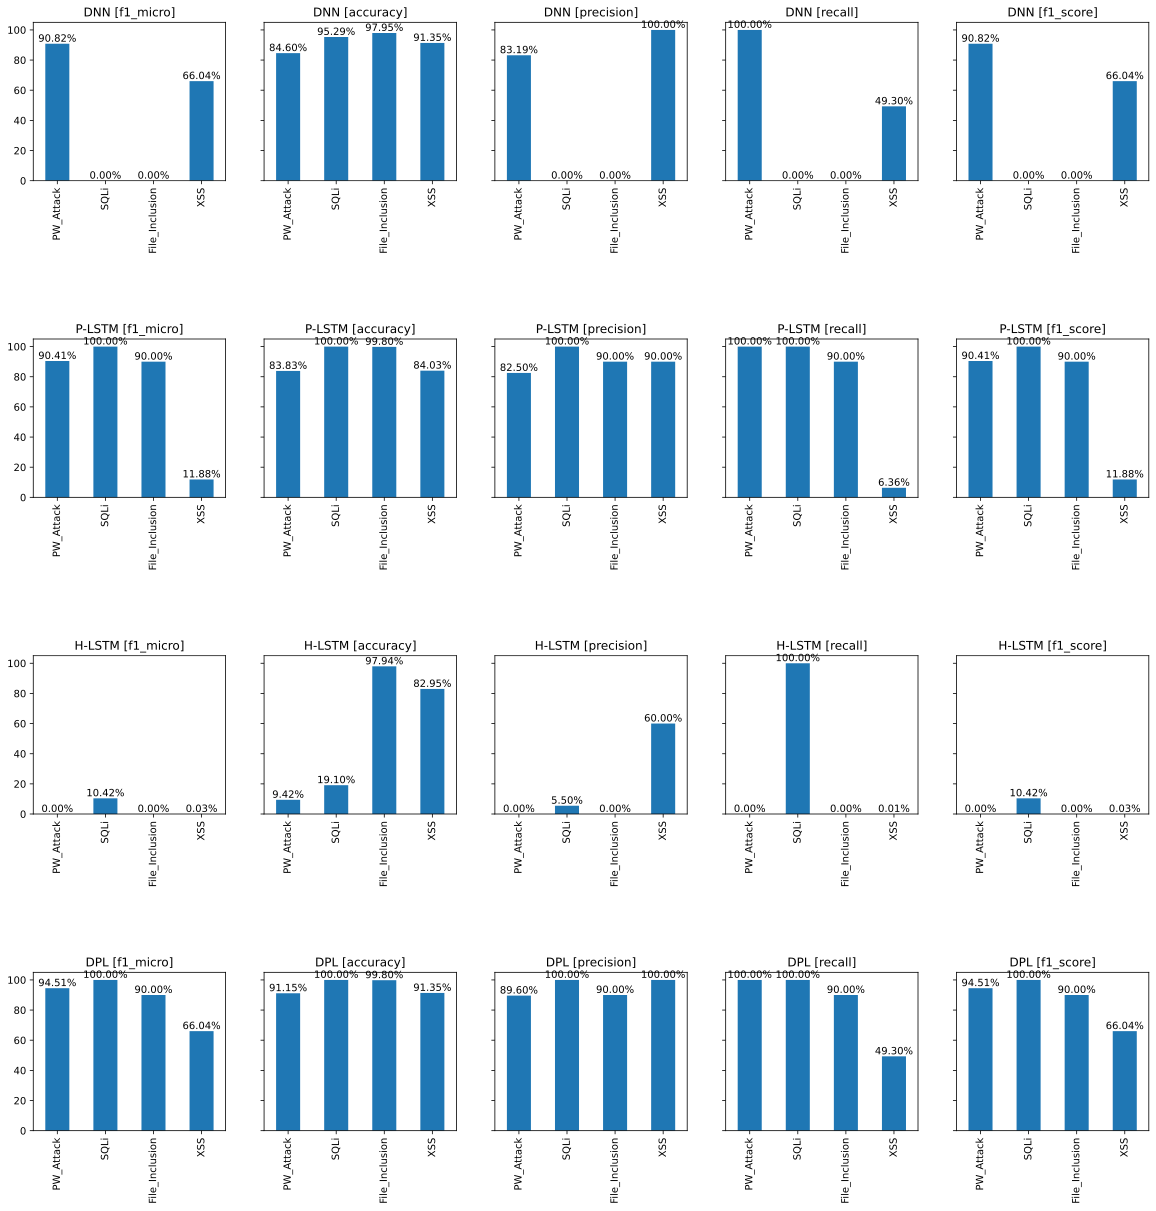

In [30]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20), sharey=True)
fig.subplots_adjust(hspace=1)
for ix, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"]):
  for iy, model in enumerate(sqldf("SELECT DISTINCT model FROM analysis")["model"]):
    _df = sqldf(f"""
          SELECT attack_name, M * 100 as score 
          FROM analysis
          WHERE model = '{model}'
            AND score_type = '{score_type}'
        """)
    _df.plot(x="attack_name", y=["score"], kind='bar', subplots=True, figsize=(7,3), title=[f"{model} [{score_type}]"], ax=axes[iy, ix], xlabel="", legend=None)
    for bar in axes[iy, ix].containers:
      axes[iy, ix].bar_label(bar, fmt='%.2f%%')

In [31]:
sqldf(f"""
          SELECT model, SUM(M) / COUNT(*) as score 
          FROM analysis
          WHERE attack_name = '{attack_name}'
          GROUP BY model, attack_name
          """)

,model,score
0,DNN,0.745443
1,P-LSTM,0.408312
2,H-LSTM,0.286026
3,DPL,0.745443


## Model - Score macro average

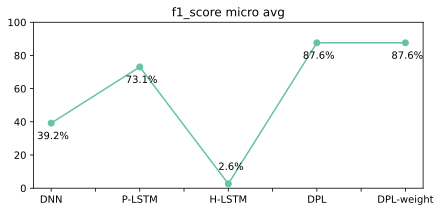

In [32]:
_df = sqldf(f"""
            SELECT model, (SUM(score) / COUNT(*)) * 100 as score 
            FROM f1_micro_type2
            WHERE 'DFL-weight' != model
            GROUP BY model
            """)
plot = _df.plot(x="model", y=f"score", kind='line', figsize=(7,3), title=f"f1_score micro avg", xlabel="", colormap="Set2", legend=False, marker="o")
plot.set_ylim(0,100)
for idx, (x,y) in enumerate(zip(_df["model"], _df["score"])):
    label = f"{y:.1f}%"
    plot.annotate(label, # this is the text
                (idx, y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(-14,-16) if y > 20 else (-10, 14), # distance from text to points (x,y)
                ha='left')

In [33]:
data.head()

,score,model,attempt,attack_name,score_type
0,0.908142,DNN,1,PW_Attack,f1_micro
1,0.908516,DNN,1,PW_Attack,f1_micro
2,0.908592,DNN,1,PW_Attack,f1_micro
3,0.909075,DNN,1,PW_Attack,f1_micro
4,0.909625,DNN,1,PW_Attack,f1_micro


In [34]:
_df = pd.concat([sqldf(f"""
            SELECT 
                (
                    CASE score_type
                        WHEN 'accuracy'
                            THEN 'Accuracy'
                        WHEN 'f1_score'
                            THEN 'f1 macro'
                        WHEN 'f1_micro'
                            THEN 'f1 micro'
                        WHEN 'precision'
                            THEN 'Precision'
                        WHEN 'recall'
                            THEN 'Recall'
                    END
                ) as score_type, 
                ROUND(SUM(M) / COUNT(*) * 1000) / 10 as score
            FROM (
                SELECT score_type, M, model
                FROM analysis
                UNION (
                SELECT 'f1_micro', score, model
                FROM f1_micro_type2
                )
            ) as df
            WHERE model = '{model}'
            GROUP BY score_type
            ORDER BY (CASE score_type
                        WHEN 'accuracy'
                            THEN 1
                        WHEN 'f1_score'
                            THEN 5
                        WHEN 'f1_micro'
                            THEN 4
                        WHEN 'precision'
                            THEN 2
                        WHEN 'recall'
                            THEN 3
                    END)
            """).rename(columns={"score":model}).set_index("score_type").transpose() for model in ["H-LSTM", "DNN", "P-LSTM", "DPL"]], axis=0)
_df


score_type,Accuracy,Precision,Recall,f1 micro,f1 macro
H-LSTM,52.4,21.8,33.3,6.0,3.5
DNN,92.3,61.1,49.8,75.0,52.3
P-LSTM,91.9,90.8,65.5,54.8,73.1
DPL,95.6,93.2,79.8,78.2,87.6


In [35]:
_df.columns

Index(['Accuracy', 'Precision', 'Recall', 'f1 micro', 'f1 macro'], dtype='object', name='score_type')

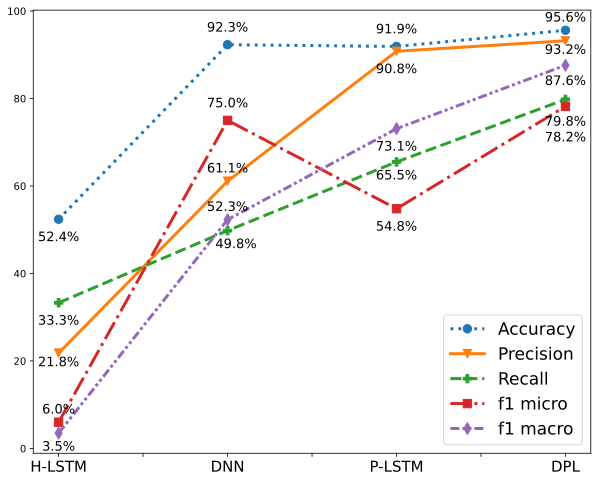

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10, 15), sharey=True)
fig.subplots_adjust(hspace=.4)
_plot = _df.plot(kind='line',  y=_df.columns, figsize=(10,8), marker='o', ax=axes)
for _linestyle, (_marker, _line) in zip(['dotted', 'solid', 'dashed', 'dashdot', (0, (3, 1, 1, 1, 1, 1))], zip(['o', 'v', 'P', 's', 'd'], _plot.get_lines())):
    _line.set_linestyle(_linestyle)
    _line.set_linewidth(3)
    _line.set_marker(_marker)
    _line.set_markersize(_line.get_markersize() * 1.4)
    
_plot.legend(_df.columns, loc='lower right', fontsize=17)

axes.set_xticklabels(axes.get_xticklabels(), fontsize=15)
_texts = [[axes.text(idx, _-5, "%.1f%%"%_, ha='center', fontsize=13) for idx, _ in enumerate(_df[v])] for v in _df.columns]

find_score = {
    'Accuracy':0, 
    'Precision':1, 
    'Recall':2, 
    'f1 micro':3, 
    'f1 macro':4,
}
find_model = {
    key: val for val, key in enumerate(["H-LSTM", "DNN", "P-LSTM", "DPL"])
}

move_text_y = lambda text, ypos: text.set_y(text.get_position()[1]+ypos)
move_text_x = lambda text, xpos: text.set_x(text.get_position()[0]+xpos)

move_text_y(_texts[1][0], 2)
move_text_y(_texts[4][0], 9)

move_text_y(_texts[0][2], 8)
move_text_y(_texts[2][2], 1), move_text_x(_texts[2][1], .05)

move_text_y(_texts[1][1], 7)
move_text_y(_texts[2][1], 8)
move_text_y(_texts[4][1], 7)

move_text_y(_texts[find_score["Accuracy"]][3], 7)
move_text_y(_texts[find_score["Precision"]][3], 2)
move_text_y(_texts[find_score["Recall"]][3], -1)
move_text_y(_texts[find_score["f1 macro"]][3], 0.5)
move_text_y(_texts[find_score["f1 micro"]][3], -3)


move_text_y(_texts[3][1], 8)
move_text_y(_texts[2][1], -7)
move_text_y(_texts[0][1], 8)
move_text_y(_texts[find_score["f1 micro"]][0], 7)
move_text_y(_texts[find_score["f1 macro"]][0], -8)
plt.style.use("grayscale")

In [37]:
# _df

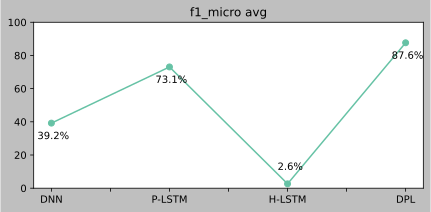

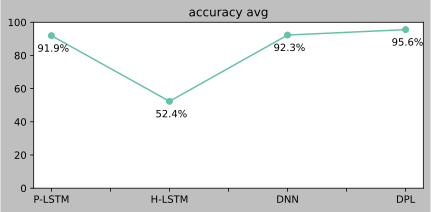

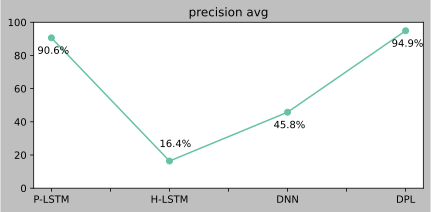

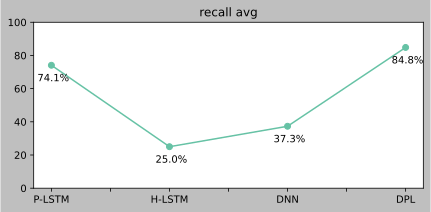

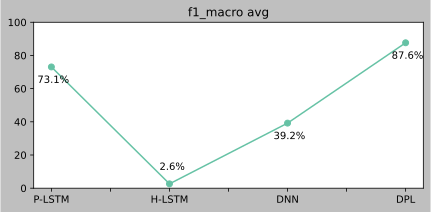

In [38]:

SUBPLOT = False
if SUBPLOT:
  fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
  fig.subplots_adjust(hspace=1)
  plots = [
    sqldf(f"""
            SELECT model, SUM(M) / COUNT(*) as score 
            FROM analysis
            WHERE score_type = '{score_type}'
            GROUP BY model
            """)\
              .plot(x="model", y=["score"], kind='line', figsize=(7,3), title=[f"{score_type} macro avg"], subplots=True,  ax=axes[iy], xlabel="", colormap="Set2")
      for iy, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"])
  ]
else:
  for iy, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"]):
    _df = sqldf(f"""
            SELECT model, (SUM(M) / COUNT(*)) * 100 as score 
            FROM analysis
            WHERE score_type = '{score_type}'
            GROUP BY model
            """)
    # _df["model"] = _df["model"].astype("str").apply(lambda x: model_name[x])
    plot = _df.plot(x="model", y=f"score", kind='line', figsize=(7,3), title=f"{score_type if score_type != 'f1_score' else 'f1_macro'} avg", xlabel="", colormap="Set2", legend=False, marker="o")
    plot.set_ylim(0,100)
    for idx, (x,y) in enumerate(zip(_df["model"], _df["score"])):
      label = f"{y:.1f}%"
      plot.annotate(label, # this is the text
                 (idx, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-14,-16) if y > 20 else (-10, 14), # distance from text to points (x,y)
                 ha='left')
      

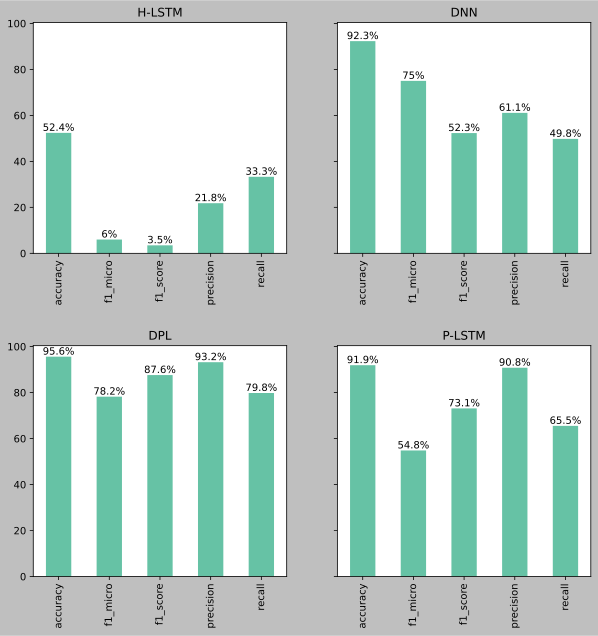

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
fig.subplots_adjust(hspace=.4)

for iy, model in enumerate(sqldf("SELECT DISTINCT model FROM analysis")["model"]):
  _data = sqldf(f"""
          SELECT score_type, ROUND(SUM(M) / COUNT(*) * 1000) / 10 as score 
          FROM (
            SELECT score_type, M, model
            FROM analysis
            UNION (
              SELECT 'f1_micro', score, model
              FROM f1_micro_type2
            )
          ) as df
          WHERE model = '{model}'
          GROUP BY score_type
          ORDER BY score_type
          """)
  plot = _data.plot(x="score_type", y=["score"], kind='bar', subplots=True, figsize=(7,7), title=[f"{model}"], ax=axes[iy % 2, iy // 2 - 1], xlabel="", legend=False, colormap="Set2")
  for bar in axes[iy % 2, iy // 2 - 1].containers:
    axes[iy % 2, iy // 2 - 1].bar_label(bar, fmt='%g%%')

In [40]:
datas = [
    ([
        sqldf(f"""SELECT model, SUM(M) / COUNT(*) as score 
            FROM analysis 
            WHERE model = '{model}'
                AND score_type = '{score_type}'
            GROUP BY score_type, model""")
            for model in sqldf("SELECT DISTINCT model FROM analysis")["model"]
    ], score_type)
    for score_type in sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"]
]

In [41]:
data.head()

,score,model,attempt,attack_name,score_type
0,0.908142,DNN,1,PW_Attack,f1_micro
1,0.908516,DNN,1,PW_Attack,f1_micro
2,0.908592,DNN,1,PW_Attack,f1_micro
3,0.909075,DNN,1,PW_Attack,f1_micro
4,0.909625,DNN,1,PW_Attack,f1_micro


# Tukey HSD

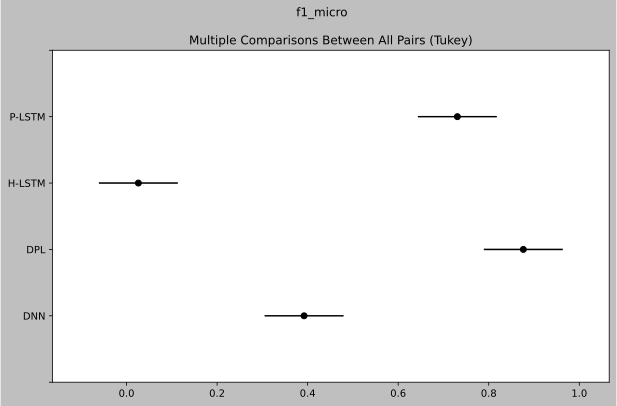

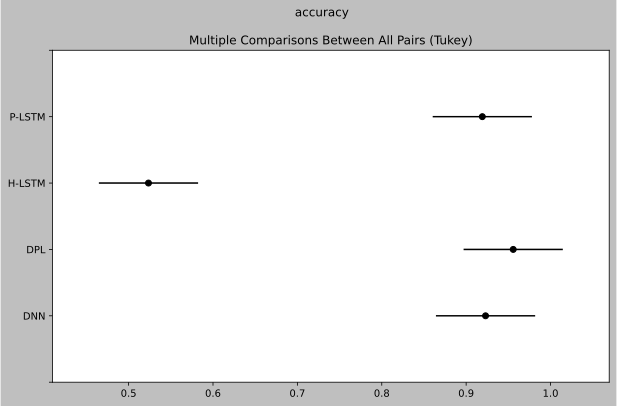

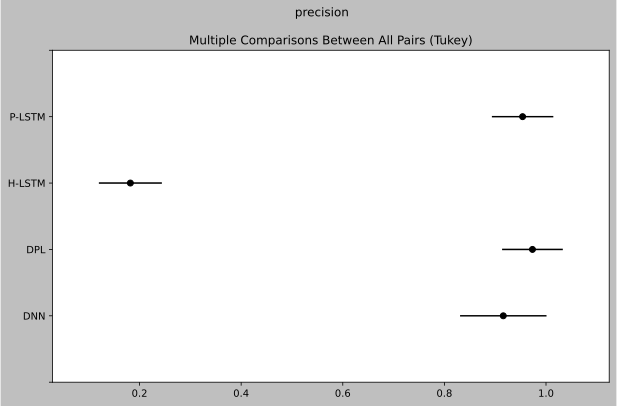

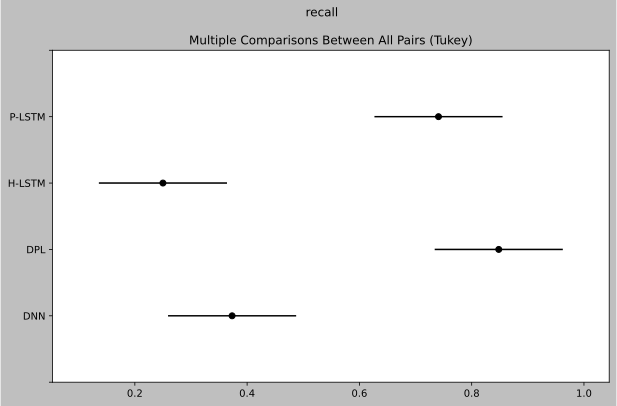

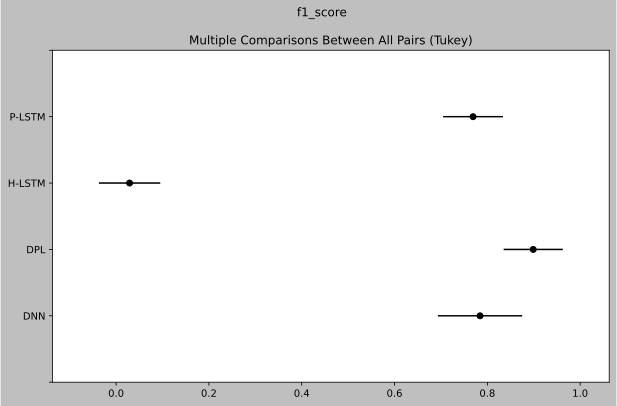

In [65]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.api  as aov 

# aov('score ~ ')

for score_type in data["score_type"].unique():
    df = sqldf(f"""
            SELECT model, score
            FROM (
                SELECT model, score, score_type
                FROM data
            )
            WHERE score_type = '{score_type}'
                AND NOT score IS NULL
            ORDER BY (
                CASE model
                    WHEN 'P-LSTM'
                        THEN 1
                    WHEN 'H-LSTM'
                        THEN 2
                    WHEN 'DNN'
                        THEN 3
                    WHEN 'DPL'
                        THEN 4
                END
            )
            """)
        # .plot(kind='box', figsize=(3,3))
    plot = pairwise_tukeyhsd(df['score'], df['model'], alpha=0.05).plot_simultaneous()
    # left, right = plot.axes[0].get_xlim()
    # plot.axes[0].set_xlim(min(-.01, left), max(.01, right))
    plot.suptitle(score_type)


# ANOVA

In [138]:
_df = sqldf(f"""
    SELECT score_type, model, 'a' as "_", ROUND(SUM(score) / COUNT(*), 4) * 100 AS score, COUNT(*) AS count
    FROM (
        SELECT model, score, 
            CASE score_type
                WHEN 'f1_score'
                    THEN 'f1 macro'
                WHEN 'f1_micro'
                    THEN 'f1 micro'
                WHEN 'accuracy'
                    THEN 'Accuracy'
                WHEN 'recall'
                    THEN 'Recall'
                WHEN 'precision'
                    THEN 'Precision'
            END AS "score_type"
        FROM data
        ORDER BY (CASE model
            WHEN 'P-LSTM'
                THEN 3
            WHEN 'H-LSTM'
                THEN 1
            WHEN 'DNN'
                THEN 2
            WHEN 'DPL'
                THEN 4
        END)
    )
    -- WHERE NOT score IS NULL
    GROUP BY model, score_type
    ORDER BY CASE score_type
            WHEN 'Accuracy'
                THEN 1
            WHEN 'Precision'
                THEN 2
            WHEN 'Recall'
                THEN 3
            WHEN 'f1 micro'
                THEN 4
            WHEN 'f1 macro'
                THEN 5
        END
    """)
print(_df.to_markdown())

|    | score_type   | model   | _   |   score |   count |
|---:|:-------------|:--------|:----|--------:|--------:|
|  0 | Accuracy     | H-LSTM  | a   |   52.35 |      40 |
|  1 | Accuracy     | DNN     | a   |   92.3  |      40 |
|  2 | Accuracy     | P-LSTM  | a   |   91.92 |      40 |
|  3 | Accuracy     | DPL     | a   |   95.58 |      40 |
|  4 | Precision    | H-LSTM  | a   |   16.37 |      40 |
|  5 | Precision    | DNN     | a   |   45.8  |      40 |
|  6 | Precision    | P-LSTM  | a   |   90.63 |      40 |
|  7 | Precision    | DPL     | a   |   94.9  |      40 |
|  8 | Recall       | H-LSTM  | a   |   25    |      40 |
|  9 | Recall       | DNN     | a   |   37.32 |      40 |
| 10 | Recall       | P-LSTM  | a   |   74.09 |      40 |
| 11 | Recall       | DPL     | a   |   84.82 |      40 |
| 12 | f1 micro     | H-LSTM  | a   |    2.61 |      40 |
| 13 | f1 micro     | DNN     | a   |   39.21 |      40 |
| 14 | f1 micro     | P-LSTM  | a   |   73.07 |      40 |
| 15 | f1 micr

In [44]:
sqldf("SELECT * FROM _df WHERE score_type='Accuracy'")

,score_type,model,_,score,count
0,Accuracy,H-LSTM,a,0.523546,40
1,Accuracy,DNN,a,0.922995,40
2,Accuracy,P-LSTM,a,0.919161,40
3,Accuracy,DPL,a,0.955767,40


In [45]:
_df.loc[_df["score_type"]=="Accuracy"]

,score_type,model,_,score,count
0,Accuracy,H-LSTM,a,0.523546,40
1,Accuracy,DNN,a,0.922995,40
2,Accuracy,P-LSTM,a,0.919161,40
3,Accuracy,DPL,a,0.955767,40


In [46]:
_df.loc[_df["score_type"]=="f1 macro"]

,score_type,model,_,score,count
16,f1 macro,H-LSTM,a,0.026122,40
17,f1 macro,DNN,a,0.392141,40
18,f1 macro,P-LSTM,a,0.730729,40
19,f1 macro,DPL,a,0.876375,40


In [134]:
_df = sqldf(f"""
            SELECT score_type, model, 'a' as "_", score
            FROM (
                SELECT model, score, 
                    CASE score_type
                        WHEN 'f1_score'
                            THEN 'f1 macro'
                        WHEN 'f1_micro'
                            THEN 'f1 micro'
                        WHEN 'accuracy'
                            THEN 'Accuracy'
                        WHEN 'recall'
                            THEN 'Recall'
                        WHEN 'precision'
                            THEN 'Precision'
                    END AS "score_type"
                FROM data
                ORDER BY (CASE model
                    WHEN 'P-LSTM'
                        THEN 3
                    WHEN 'H-LSTM'
                        THEN 1
                    WHEN 'DNN'
                        THEN 2
                    WHEN 'DPL'
                        THEN 4
                END)
            )
            -- WHERE NOT score IS NULL
            ORDER BY CASE score_type
                    WHEN 'Accuracy'
                        THEN 1
                    WHEN 'Precision'
                        THEN 2
                    WHEN 'Recall'
                        THEN 3
                    WHEN 'f1 micro'
                        THEN 4
                    WHEN 'f1 macro'
                        THEN 5
                END
            """)

,score_type,model,_,score
0,Accuracy,H-LSTM,a,0.095242
1,Accuracy,H-LSTM,a,0.190519
2,Accuracy,H-LSTM,a,0.978978
3,Accuracy,H-LSTM,a,0.830360
4,Accuracy,H-LSTM,a,0.094777
...,...,...,...,...
795,f1 macro,DPL,a,0.652216
796,f1 macro,DPL,a,0.948298
797,f1 macro,DPL,a,1.000000
798,f1 macro,DPL,a,1.000000


In [48]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
for _score_type in [
    'Accuracy', 
    'Precision', 
    'Recall', 
    'f1 macro', 
    'f1 micro', 
                ]:
    anova_df = anova_lm(
        ols('score ~ C(model)', data=_df.loc[(_df["score_type"]==_score_type)]).fit()
    )
    print(_score_type)
    print("%.2f"%(anova_df["F"]["C(model)"]))
    print("%.2f"%(anova_df["PR(>F)"]["C(model)"]))
    print()

Accuracy
41.08
0.00

Precision
127.61
0.00

Recall
21.29
0.00

f1 macro
121.25
0.00

f1 micro
63.63
0.00



# CA

In [49]:
import altair as alt

def getCA_plot(df, ca=None, title=None, arrows=[False, False], component_name=["attack_name", "model"], interactive=True, annotProps={"fontSize": 12}, original_ca=False,  debug=False):
    arrow1, arrow2 = arrows if len(arrows) == 2 else [arrows, arrows]
    com1, com2 = component_name
    if not ca:
        ca = prince.CA().fit(df)
    # attack
    cc = ca.column_coordinates(df).reset_index()
    cc.columns = ['name', 'x', 'y']
    cc["angle"] = np.rad2deg(np.abs(np.arctan2(cc["x"].sum(), cc["y"].sum())))
    cc["component"] = com1
    
    if arrow1:
        cc_plot = alt.Chart(cc).mark_point(shape="circle", color='#889fbf', size=30, filled=True).encode(
            x='x', y='y', angle="angle",
            tooltip=[
                "x", "y", "component"
            ],
            color=alt.Color('component')
        )
        cc_plot.properties(angle=cc["angle"])
    else:
        cc_plot = alt.Chart(cc).mark_circle(color='#889fbf', size=50).encode(
            x='x', y='y',
            tooltip=[
                "x", "y", "component"
            ],
            color=alt.Color('component')
        )
    
    # model
    rc = ca.row_coordinates(df).reset_index()
    rc.columns = ['name', 'x', 'y'] 
    rc["angle"] = np.rad2deg(np.arctan2(rc["x"], rc["y"]))
    rc["component"] = com2
    if arrow2:
        rc_plot = alt.Chart(rc).mark_point(shape="circle", color='#ebad69', size=30, filled=True).encode(
            x='x', y='y', angle="angle",
            tooltip=[
                'x', "y", "component"
            ],
            color=alt.Color('component')
        )
    else:
        rc_plot = alt.Chart(rc).mark_circle(color='#ebad69', size=50).encode(
            x='x', y='y',
            tooltip=[
                'x', "y", "component"
            ],
            color=alt.Color('component')
        )
    crc_df = pd.concat([cc, rc], ignore_index=True)
    
    
    
    
    if interactive:
        cc_plot = cc_plot.interactive()
    if interactive:
        rc_plot = rc_plot.interactive()
    points = cc_plot + rc_plot
    if original_ca: points = ca.plot(df)
    if arrow1:
        arrow1_pd = cc.copy(True)
        arrow1_pd["x2"] = arrow1_pd["x"]
        arrow1_pd["y2"] = arrow1_pd["y"]
        arrow1_pd["x"] = arrow1_pd["x"].apply(lambda x: 0)
        arrow1_pd["y"] = arrow1_pd["y"].apply(lambda x: 0)
        arrow1_pd["color"] = arrow1_pd["y"].apply(lambda x: "#889fbf")
        arrow_map1 = alt.Chart(arrow1_pd).mark_rule().encode(color=alt.Color('color').scale(None),x='x',y='y',x2='x2',y2='y2')
        points = arrow_map1 + points
    if arrow2:
        arrow2_pd = rc.copy(True)
        arrow2_pd["x2"] = arrow2_pd["x"]
        arrow2_pd["y2"] = arrow2_pd["y"]
        arrow2_pd["x"] = arrow2_pd["x"].apply(lambda x: 0)
        arrow2_pd["y"] = arrow2_pd["y"].apply(lambda x: 0)
        arrow2_pd["color"] = arrow2_pd["y"].apply(lambda x: "#ebad69")

        arrow_map2 = alt.Chart(arrow2_pd).mark_rule().encode(color=alt.Color('color').scale(None),x='x',y='y',x2='x2',y2='y2')
        points = arrow_map2 + points
    
    y_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(stroke="gray").encode(y='y')
    x_line = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(stroke="gray").encode(x='x')
    
    annot = alt.Chart(crc_df).mark_text(
        align='left',
        baseline='middle',
        dx = 7,
    ).encode(
        x='x',
        y='y',
        text='name',
        size=alt.value(annotProps.get("fontSize"))
    )
    plot = points + annot + y_line + x_line
    print(cc)
    print(rc)
    
    if title:
        plot.title = title
    return plot

In [50]:
score_types = data["score_type"].unique()
cas = []
import os
for stype in [*score_types, 'f1_micro']:
    input_X = sqldf(f"""
                    SELECT model, attack_name, SUM(score) / COUNT(*) * 100 as score
                    FROM (
                        SELECT model, score, score_type, attack_name
                        FROM data
                    )
                    WHERE score_type = '{stype}'
                        AND NOT score IS NULL
                    GROUP BY model, attack_name
                    """)
    input_X = input_X.pivot(index="model", columns="attack_name", values="score").fillna(0)
    # input_X.to_csv(os.path.join("statistics", f"{stype}_analysis.csv"))
    ca = prince.CA().fit(input_X)
    # plot = lambda : getCA_plot(input_X, ca, stype)
    cas.append([ca, input_X, stype])

In [51]:

def get_matrix_ca(score_type):
    res =  sqldf(f"""
        SELECT model, attack_name, SUM(score) / COUNT(*) * 100 as score
        FROM (
            SELECT model, score, attack_name,
                CASE score_type
                    WHEN 'f1_score'
                        THEN 'f1 macro'
                    WHEN 'f1_micro'
                        THEN 'f1 micro'
                    WHEN 'accuracy'
                        THEN 'Accuracy'
                    WHEN 'recall'
                        THEN 'Recall'
                    WHEN 'precision'
                        THEN 'Precision'
                END AS "score_type"
            FROM data
        )
        WHERE score_type = '{score_type}'
            AND NOT score IS NULL
        GROUP BY model, attack_name
        """).pivot(index="model", columns="attack_name", values="score")
    res.index.name = None
    res.columns.name = None
    return res


get_matrix_ca("f1 macro")

,File_Inclusion,PW_Attack,SQLi,XSS
DNN,NaN,90.821104,NaN,66.035496
DPL,100.0,94.514314,100.00000,66.035496
H-LSTM,0.0,0.000000,10.42374,0.041859
P-LSTM,100.0,90.410741,100.00000,13.200982


In [131]:
def chi2(attack_name):
    from scipy.stats import chisquare, chi2_contingency
    from statsmodels.stats.proportion import proportions_chisquare
    res = chi2_contingency(get_matrix_ca(attack_name).fillna(0))
    res.expected_freq
    if res.pvalue < 0.001:
        return (f"{attack_name}에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2({res.dof})={res.statistic:.2f}, p<0.001")
    return (f"{attack_name}에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2({res.dof})={res.statistic:.2f}, p={res.pvalue:.3f}")


In [132]:
print("\n".join([chi2("f1 micro"), chi2("f1 macro"), chi2("Accuracy"), chi2("Precision"), chi2("Recall")]))

f1 micro에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=240.84, p<0.001
f1 macro에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=247.55, p<0.001
Accuracy에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=94.09, p<0.001
Precision에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=333.02, p<0.001
Recall에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=431.04, p<0.001


'f1 macro에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=247.55, p<0.001'

'Accuracy에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=94.09, p<0.001'

'Precision에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=333.02, p<0.001'

'Recall에 대한 행과 열의 독립성 검정결과, 통계적으로 유의하였다, chi2(9)=431.04, p<0.001'

In [54]:
# Accuracy
ca, input_X, stype = cas[0]
print(ca)
getCA_plot(input_X, ca, stype, arrows=[True, False], original_ca=True)

             name         x         y      angle    component
0  File_Inclusion -0.464856 -0.210380  65.095696  attack_name
1       PW_Attack  0.330031 -0.077372  65.095696  attack_name
2            SQLi -0.544690  0.201455  65.095696  attack_name
3             XSS  0.745155  0.116771  65.095696  attack_name
     name         x         y       angle component
0     DNN  0.988421  0.027672   88.396334     model
1     DPL -0.088850  0.029137  -71.844101     model
2  H-LSTM -1.060468  1.277032  -39.706797     model
3  P-LSTM -0.385961 -0.095446 -103.890215     model


alt.LayerChart(...)

In [55]:
ca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.261,87.74%,87.74%
1,0.025,8.35%,96.09%


In [56]:
ca.row_contributions_

,0,1
DNN,0.725233,0.005970
DPL,0.013097,0.014791
H-LSTM,0.055610,0.846900
P-LSTM,0.206060,0.132340


In [57]:
# precision
ca, input_X, stype = cas[1]
getCA_plot(input_X, ca, stype, [True, False], original_ca=True)

             name         x         y     angle    component
0  File_Inclusion  0.246886  0.015685  91.76818  attack_name
1       PW_Attack -0.336647 -0.017336  91.76818  attack_name
2            SQLi -0.266150  0.018121  91.76818  attack_name
3             XSS  0.219033 -0.020696  91.76818  attack_name
     name         x         y      angle component
0     DNN -0.098450 -0.014138 -98.172327     model
1     DPL -0.124664 -0.013560 -96.207692     model
2  H-LSTM  0.613240  0.000629  89.941224     model
3  P-LSTM -0.120807  0.027939 -76.978246     model


alt.LayerChart(...)

In [58]:
# recall
ca, input_X, stype = cas[2]
getCA_plot(input_X, ca, stype, (True, False), original_ca=True)

             name         x         y      angle    component
0  File_Inclusion -0.599983 -0.118437  86.489374  attack_name
1       PW_Attack  0.026896  0.489052  86.489374  attack_name
2            SQLi -0.527930 -0.173060  86.489374  attack_name
3             XSS  0.554048 -0.163998  86.489374  attack_name
     name         x         y       angle component
0     DNN  0.645288  0.480364   53.335372     model
1     DPL -0.289376 -0.016091  -93.182606     model
2  H-LSTM  1.020550 -0.596019  120.285681     model
3  P-LSTM -0.295769 -0.049275  -99.458523     model


alt.LayerChart(...)

In [59]:
# f1_score
ca, input_X, stype = cas[3]
getCA_plot(input_X, ca, stype, (True, False), original_ca=True)

             name         x         y      angle    component
0  File_Inclusion -0.084161 -0.620206  88.615611  attack_name
1       PW_Attack  0.511999  0.021833  88.615611  attack_name
2            SQLi -0.748697  0.210269  88.615611  attack_name
3             XSS  0.820815  0.400186  88.615611  attack_name
     name         x         y       angle component
0     DNN  1.022935  0.437788   66.830425     model
1     DPL  0.045270 -0.113241  158.210262     model
2  H-LSTM -1.247081  0.627300  -63.296956     model
3  P-LSTM -0.146297 -0.302589 -154.197020     model


alt.LayerChart(...)

In [60]:
# f1_score micro
ca, input_X, stype = cas[4]
getCA_plot(input_X, ca, stype, (True, False), original_ca=True)

             name         x         y      angle    component
0  File_Inclusion -0.458311 -0.210536  67.520521  attack_name
1       PW_Attack  0.347688 -0.065288  67.520521  attack_name
2            SQLi -0.536384  0.214594  67.520521  attack_name
3             XSS  0.747737  0.102912  67.520521  attack_name
     name         x         y       angle component
0     DNN  1.009961  0.034530   88.041857     model
1     DPL -0.093521  0.017878  -79.177446     model
2  H-LSTM -1.039593  1.338937  -37.826884     model
3  P-LSTM -0.374888 -0.085224 -102.807491     model


alt.LayerChart(...)